In [1]:
import functools
import io
import itertools
import operator

import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image


In [3]:
# Create a dictionary describing the features.
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature(shape=[], dtype=tf.float32, allow_missing=True, default_value=0),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature(shape=[], dtype=tf.float32, allow_missing=True, default_value=0),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature(shape=[], dtype=tf.float32, allow_missing=True, default_value=0),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature(shape=[], dtype=tf.float32, allow_missing=True, default_value=0),
    'image/object/class/text': \
    tf.io.FixedLenSequenceFeature(shape=[], dtype=tf.string, allow_missing=True, default_value=''),
    'image/object/class/label': \
    tf.io.FixedLenSequenceFeature(shape=[], dtype=tf.int64, allow_missing=True, default_value=0),
}


def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

## Datasets Counting

In [2]:
raw_train_dataset = tf.data.TFRecordDataset('/home/ting/Private-Projects/Tensorflow/mobilenetv2-od/_datasets/train_2.tfrecord')
raw_val_dataset = tf.data.TFRecordDataset('/home/ting/Private-Projects/Tensorflow/mobilenetv2-od/_datasets/val.tfrecord')

2022-06-02 15:23:50.785972: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
parsed_train_dataset = raw_train_dataset.map(_parse_image_function)
parsed_val_dataset = raw_val_dataset.map(_parse_image_function)

In [7]:
train_count = 0
train_face_count = 0
val_count = 0
val_face_count = 0

for image_features in parsed_train_dataset:
    train_count += 1
    train_face_count += len(image_features['image/object/bbox/xmin'].numpy())

for image_features in parsed_val_dataset:
    val_count += 1
    val_face_count += len(image_features['image/object/bbox/xmin'].numpy())

print(f'train_count: {train_count}')
print(f'train_face_count: {train_face_count}')
print(f'val_count: {val_count}')
print(f'val_face_count: {val_face_count}')


train_count: 12880
train_face_count: 148343
val_count: 3226
val_face_count: 36767


## Visualize

In [2]:
# raw_image_dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/Shared 01/MobileNetv2/Kangaroo_Datasets/tfrecords/train.record')
# raw_image_dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/Shared 01/MobileNetv2/WIDER_Face_Datasets/tfrecords/train.tfrecord')
# raw_image_dataset = tf.data.TFRecordDataset('/home/ting/Private-Projects/Tensorflow/mobilenetv2-od/_datasets/train.tfrecord')
raw_image_dataset = tf.data.TFRecordDataset('/home/ting/Private-Projects/Tensorflow/mobilenetv2-od/_datasets/train_2.tfrecord')
print(type(raw_image_dataset))

<class 'tensorflow.python.data.ops.readers.TFRecordDatasetV2'>


2022-05-16 09:54:59.626311: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:



parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset element_spec={'image/encoded': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/format': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image/object/bbox/xmax': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'image/object/bbox/xmin': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'image/object/bbox/ymax': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'image/object/bbox/ymin': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'image/object/class/label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'image/object/class/text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'image/source_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/width': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [4]:
count = 0
for image_features in parsed_image_dataset:
    count+=1
print(count)

12880


In [8]:
count = 0
num_row = 10
num_col = 4
raw_imgs = []
filenames = []
img_hs = []
img_ws = []
xmin_list = []
xmax_list = []
ymin_list = []
ymax_list = []

for image_features in parsed_image_dataset:
    count+=1
    # print(image_features['image/height'].numpy())
    # print(image_features['image/object/class/text'].numpy())
    # print(type(image_features['image/object/bbox/xmin']))
    # print(image_features['image/filename'].numpy().decode('ascii'))
    raw_imgs.append(image_features['image/encoded'].numpy())
    filenames.append(image_features['image/filename'].numpy().decode('ascii'))
    img_hs.append(image_features['image/height'].numpy())
    img_ws.append(image_features['image/width'].numpy())
    xmin_list.append(image_features['image/object/bbox/xmin'].numpy())
    xmax_list.append(image_features['image/object/bbox/xmax'].numpy())
    ymin_list.append(image_features['image/object/bbox/ymin'].numpy())
    ymax_list.append(image_features['image/object/bbox/ymax'].numpy())

    # display.display(display.Image(data=image_raw))
    if count >= num_row * num_col:
        break
print(count)

40


In [6]:
title_font = {'fontname':'Arial', 'size':'3', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
              

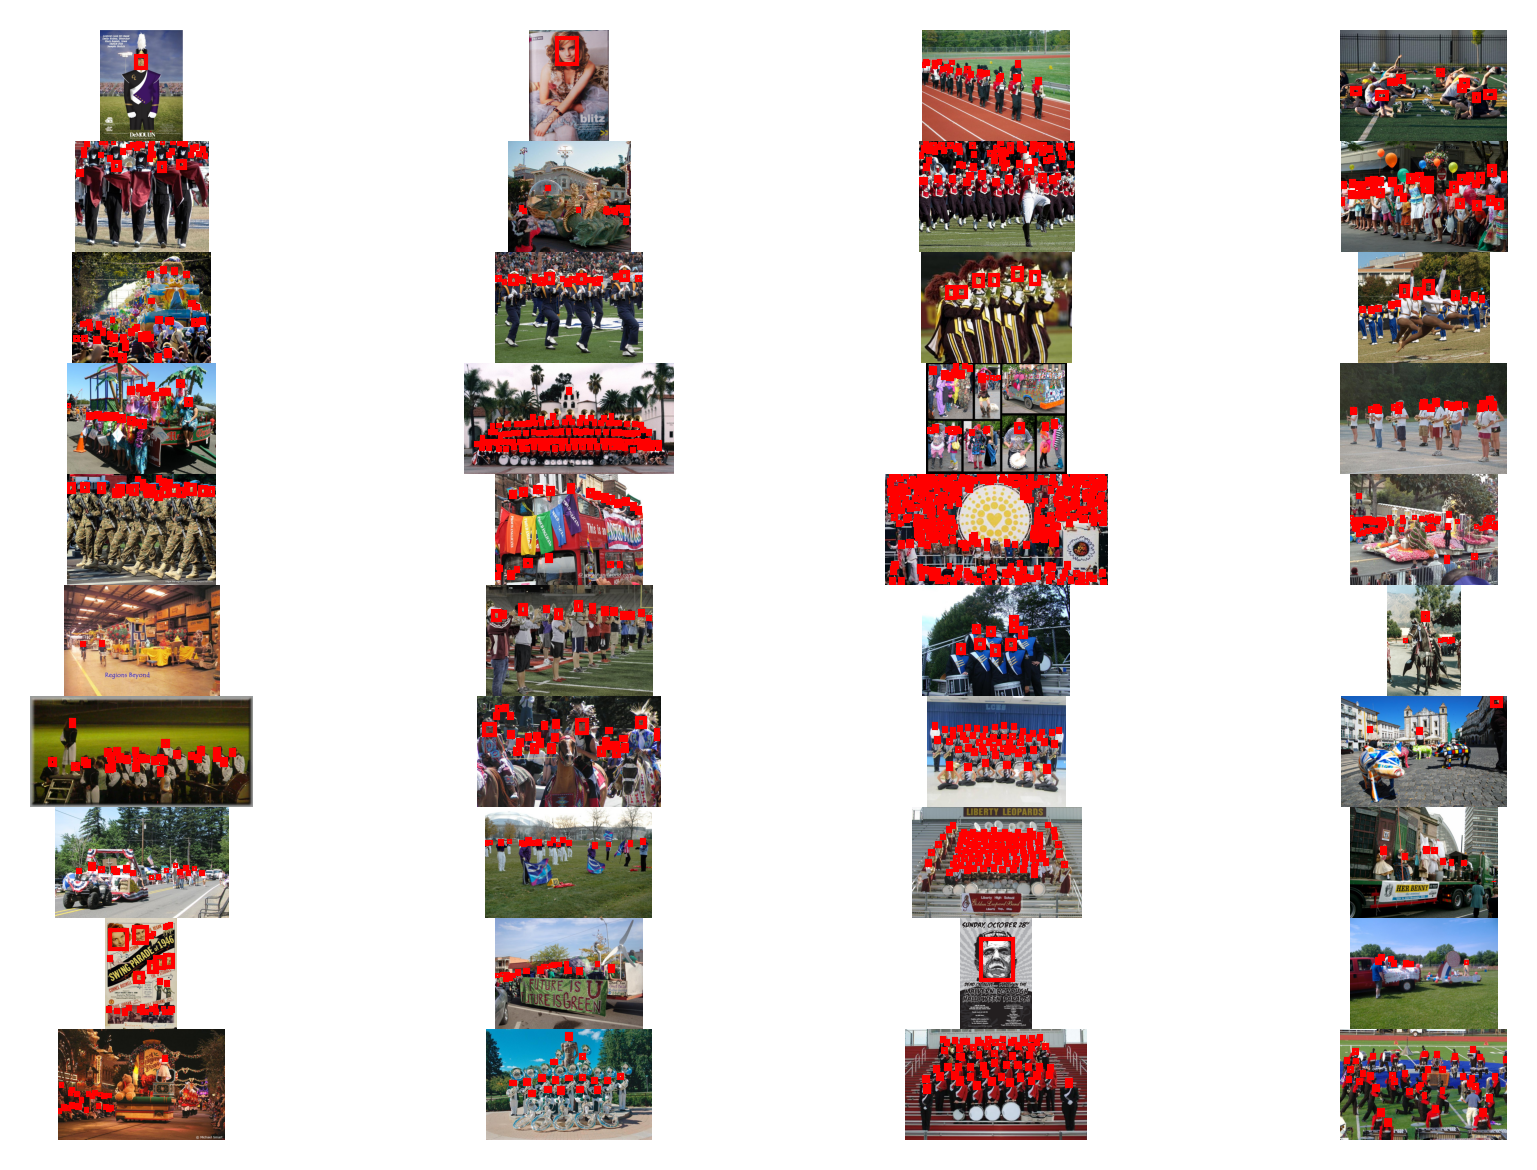

In [16]:

fig, axes = plt.subplots(num_row, num_col, gridspec_kw = {'wspace':0, 'hspace':0})
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.4, 
                    top=0.4, wspace=0, hspace=0)
fig.set_dpi(300)
axes = functools.reduce(operator.iconcat, axes, [])
for i in range(len(axes)):
    if i < len(raw_imgs):
        byte_img = raw_imgs[i]
        img_h = img_hs[i]
        img_w = img_ws[i]
        xmin = (xmin_list[i] * img_w).astype(int)
        xmax = (xmax_list[i] * img_w).astype(int)
        ymin = (ymin_list[i] * img_h).astype(int)
        ymax = (ymax_list[i] * img_h).astype(int)
        image = np.array(Image.open(io.BytesIO(byte_img)))
        filename = filenames[i]
        for j in range(len(xmin)):
            # process bbox
            bl_x = xmin[j]
            bl_y = ymin[j]
            bb_w = xmax[j] - xmin[j]
            bb_h = ymax[j] - ymin[j]

            # bottom left (x, y), width, height
            rect = patches.Rectangle(
                (bl_x, bl_y),
                bb_w, bb_h,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            axes[i].add_patch(rect)
        axes[i].imshow(image)
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].set_aspect('equal')
        # axes[i].set_title(filename, **title_font)

    axes[i].set_axis_off()
fig.tight_layout()
plt.tight_layout()
plt.show()

In [8]:
ind = 10
byte_img = raw_imgs[ind]
img_h = img_hs[ind]
img_w = img_ws[ind]
xmin = (xmin_list[ind] * img_w).astype(int)
xmax = (xmax_list[ind] * img_w).astype(int)
ymin = (ymin_list[ind] * img_h).astype(int)
ymax = (ymax_list[ind] * img_h).astype(int)
image = np.array(Image.open(io.BytesIO(byte_img)))
print(image.shape)  # (height, width, channels)
print(f'xmin: {xmin}')
print(f'xmax: {xmax}')
print(f'ymin: {ymin}')
print(f'ymax: {ymax}')


(755, 1024, 3)
xmin: [178 248 363 468 629 745]
xmax: [233 307 422 521 685 800]
ymin: [238 235 157 153 109 138]
ymax: [311 308 230 225 191 215]


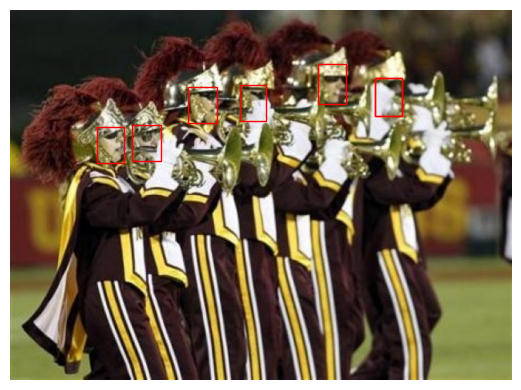

In [9]:
# Create figure and axes
fig, ax = plt.subplots()
fig.set_dpi(100)

ax.imshow(image)

for j in range(len(xmin)):
    # process bbox
    bl_x = xmin[j]
    bl_y = ymin[j]
    bb_w = xmax[j] - xmin[j]
    bb_h = ymax[j] - ymin[j]

    # bottom left (x, y), width, height
    rect = patches.Rectangle(
        (bl_x, bl_y),
        bb_w, bb_h,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

ax.add_patch(rect)
ax.set_axis_off()
fig.tight_layout()
plt.show()
